# Kan HPO

## install + imports

### imports

In [2]:
import kan
from kan import MultKAN
from kan import KAN
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import os
import optuna
import wandb


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
import json
# Pfad zur lokalen JSON-Datei
config_file_path = './config_list.json'

# Laden der Konfigurationsliste aus der JSON-Datei
with open(config_file_path, 'r') as file:
    config_list = json.load(file)
secret_value_0 = config_list[0]['api_key']

## Dataset and preprocessing

In [5]:
# read train and test data
train = pd.read_csv('../data/MNIST/mnist_train.csv')
test = pd.read_csv('../data/MNIST/mnist_test.csv')
from sklearn.model_selection import train_test_split
train, eval = train_test_split(train, test_size=0.2, random_state=42)

In [6]:
from torchvision import transforms
# convert data to numpy arrays
x_train = train.drop('label', axis=1).values
x_eval = eval.drop('label', axis=1).values
x_test = test.drop('label', axis=1).values

y_train = train['label'].values
y_eval = eval['label'].values
y_test = test['label'].values

In [7]:
# set target size to scale images
target_size = 8

# define transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor()
])

# transform the data
def transform_images(images):
    transformed_images = []
    for image in images:
        image = image.reshape(28, 28).astype(np.uint8)
        image = transform(image)
        image = image.view(-1)
        transformed_images.append(image)
    return torch.stack(transformed_images)

train_input = transform_images(x_train)
eval_input = transform_images(x_eval)
test_input = transform_images(x_test)
train_label = torch.tensor(y_train, dtype=torch.int64)
eval_label = torch.tensor(y_eval, dtype=torch.int64)
test_label = torch.tensor(y_test, dtype=torch.int64)

In [8]:
train_input.shape, eval_input.shape, test_input.shape, train_label.shape,eval_label.shape, test_label.shape

(torch.Size([48000, 64]),
 torch.Size([12000, 64]),
 torch.Size([10000, 64]),
 torch.Size([48000]),
 torch.Size([12000]),
 torch.Size([10000]))

In [9]:
dataset = {
    'train_input': train_input,
    'eval_input': eval_input,
    'test_input': test_input,
    'train_label': train_label,
    'eval_label': eval_label,
    'test_label': test_label

}

In [10]:
# Convert labels to Long tensors
dataset['train_label'] = dataset['train_label'].long()
dataset['test_label'] = dataset['test_label'].long()
dataset['eval_label'] = dataset['eval_label'].long()

In [11]:
dataset['train_input'] = train_input.to(device)
dataset['test_input'] = test_input.to(device)
dataset['train_label'] = train_label.to(device)
dataset['test_label'] = test_label.to(device)
dataset['eval_input'] = eval_input.to(device)
dataset['eval_label'] = eval_label.to(device)

## Model init

In [12]:
# Log in to Weights & Biases using the provided API key
wandb.login(key=secret_value_0)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lukasgrengames. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\a829727\_netrc


True

### 1 hidden

In [13]:
# Define the optimization function
def objective(trial):
    hidden_1 = trial.suggest_categorical('hidden_1', [1, 2, 3, 5, 10])
    run_name = f"hidden_size_{hidden_1}"

    # Initialize Weights & Biases for each trial with a unique run name
    wandb.init(project="KAN_hidden_1_hpo_test", name=run_name, reinit=True)

    grid = 3
    k = 3
    seed = 42
    input_dim = train_input.shape[1]  # Number of input features
    output_dim = 10  # Number of classes

    Parameter = hidden_1 * (input_dim + output_dim) * (grid + k + 2)
    print(f"Parameter count = {Parameter}")

    model = KAN(width=[input_dim, hidden_1, output_dim], grid=grid, k=k, seed=seed)  # Simplified model configuration

    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

    def eval_acc():
        return torch.mean((torch.argmax(model(dataset['eval_input']), dim=1) == dataset['eval_label']).float())

    results = model.fit(dataset, opt="LBFGS", steps=2, metrics=(train_acc, test_acc, eval_acc),
                        loss_fn=torch.nn.CrossEntropyLoss(), update_grid=False)

    # Log metrics to WANDB
    for step in range(len(results['train_loss'])):
        wandb.log({
            'step': step,
            'train_loss': results['train_loss'][step],
            'test_loss': results['test_loss'][step],
            'reg': results['reg'][step],
            'train_acc': results['train_acc'][step],
            'test_acc': results['test_acc'][step],
            'eval_acc': results['eval_acc'][step]
        })

    wandb.finish()
    return results['eval_acc'][-1]

# Define the search space for Grid Search
search_space = {
    'hidden_1': [1, 2, 3, 5, 10]
}

# Create the study using GridSampler
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space), direction='maximize')
study.optimize(objective, n_trials=len(search_space['hidden_1']))

# Save results
df = study.trials_dataframe()
df.to_csv('/content/drive/MyDrive/KAN/HPO_Results/optuna_results_1_hidden.csv', index=False)

print("Optimization completed and results saved to optuna_results_1_hidden.csv")


[I 2024-07-23 19:29:40,313] A new study created in memory with name: no-name-b1b3c406-fb69-4158-a3e2-03d26fda185c


Parameter count = 1184
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.10e+00 | test_loss: 1.10e+00 | reg: 5.65e+01 | : 100%|█| 2/2 [04:01<00:00, 120.91s/i


saving model version 0.1


eval_acc,▁█
reg,▁█
step,▁█
test_acc,▁█
test_loss,█▁
train_acc,▁█
train_loss,█▁
eval_acc,0.58083
reg,56.53035
step,1
test_acc,0.5726


[I 2024-07-23 19:33:53,675] Trial 0 finished with value: 0.5808333158493042 and parameters: {'hidden_1': 2}. Best is trial 0 with value: 0.5808333158493042.


Parameter count = 1776
checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                            | 0/2 [01:33<?, ?it/s]
[W 2024-07-23 19:35:29,924] Trial 1 failed with parameters: {'hidden_1': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\KAN\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\a829727\AppData\Local\Temp\ipykernel_15412\1013698610.py", line 29, in objective
    results = model.fit(dataset, opt="LBFGS", steps=2, metrics=(train_acc, test_acc, eval_acc),
  File "c:\Users\a829727\OneDrive - Eviden\Dokumente\Uni\Semester 6\AML\KAN-project\KAN-Model\kan\MultKAN.py", line 907, in fit
    optimizer.step(closure)
  File "c:\ProgramData\anaconda3\envs\KAN\lib\site-packages\torch\optim\optimizer.py", line 391, in wrapper
    out = func(*args, **kwargs)
  File "c:\ProgramData\anaconda3\envs\KAN\lib\site-packages\torch\utils\_contextlib.py", line 115, 

KeyboardInterrupt: 

### 2 hidden

In [ ]:
# Definiere die Optimierungsfunktion
def objective(trial):
    hidden_1 = trial.suggest_categorical('hidden_1', [1, 2, 3, 5, 10])
    hidden_2 = trial.suggest_categorical('hidden_2', [1, 2, 3, 5, 10])
    grid = 3
    k = 3
    seed = 42
    input_dim = train_input.shape[1]  # Anzahl der Eingabefunktionen
    output_dim = 10  # Anzahl der Klasse

    Parameter = hidden_1 * (input_dim + output_dim) * (grid + k + 2)
    print(f"Parameter count = {Parameter}")

    model = KAN(width=[input_dim, hidden_1,hidden_2, output_dim], grid=grid, k=k, seed=seed)  # Vereinfachte Modellkonfiguration

    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

    def eval_acc():
        return torch.mean((torch.argmax(model(dataset['eval_input']), dim=1) == dataset['eval_label']).float())

    results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc, eval_acc),
                        loss_fn=torch.nn.CrossEntropyLoss(), update_grid=False)

    return results['eval_acc'][-1]

# Starte die Optimierung
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

# Ergebnisse speichern
df = study.trials_dataframe()
df.to_csv('optuna_results_2_hidden.csv', index=False)

print("Optimization completed and results saved to optuna_results.csv")


## Training

In [ ]:
#Parameter
hidden_1 = 3
hidden_2 = 0
steps = 5
grid = 3
k = 3
seed = 42
input_dim = train_input.shape[ 1 ]   # Anzahl der Eingabefunktionen
output_dim = 10   # Anzahl der Klasse

#Count
if hidden_2>0:
    Parameter = (hidden_1*input_dim+hidden_1*hidden_2+hidden_2*output_dim)*(grid+k)
    print(f"Parameter count = {Parameter}")
else:
    Parameter = hidden_1*(input_dim+output_dim)*(grid+k+2)
    print(f"Parameter count = {Parameter}")

## Results

In [ ]:
results

{'train_loss': [array(1.3576002, dtype=float32),
  array(1.0865319, dtype=float32),
  array(0.9643007, dtype=float32),
  array(0.89410037, dtype=float32),
  array(0.8580867, dtype=float32)],
 'test_loss': [array(1.3629447, dtype=float32),
  array(1.0864588, dtype=float32),
  array(0.94882643, dtype=float32),
  array(0.8835156, dtype=float32),
  array(0.84808546, dtype=float32)],
 'reg': [array(0., dtype=float32),
  array(0., dtype=float32),
  array(0., dtype=float32),
  array(0., dtype=float32),
  array(81.611435, dtype=float32)],
 'train_acc': [0.31299999356269836,
  0.6056249737739563,
  0.6848958134651184,
  0.7279375195503235,
  0.7507500052452087],
 'test_acc': [0.31119999289512634,
  0.607200026512146,
  0.6898999810218811,
  0.7332000136375427,
  0.754800021648407],
 'eval_acc': [0.31191667914390564,
  0.6071666479110718,
  0.6854166388511658,
  0.7315833568572998,
  0.7518333196640015]}

In [ ]:
train_loss = results['train_loss']

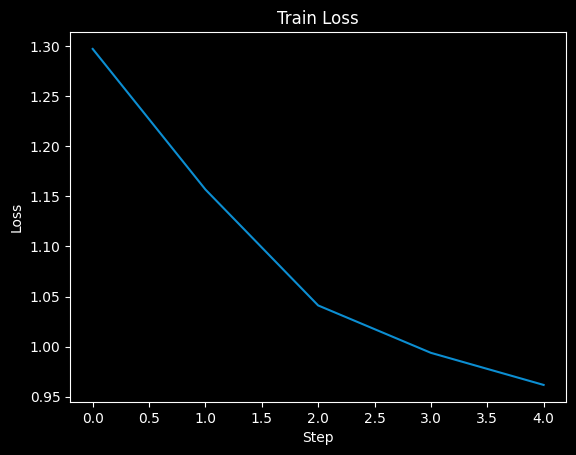

In [ ]:
# Linienfarbe
line_color = [0.047058823529411764, 0.5568627450980392, 0.8235294117647058]

# Plotten
plt.figure(facecolor='black')  # Schwarzer Hintergrund
plt.plot(train_loss, color=line_color)

# Anpassen der Plot-Elemente für schwarzen Hintergrund
plt.gca().set_facecolor('black')  # Hintergrund der Plotfläche
plt.gca().tick_params(colors='white')  # Achsenfarben
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['right'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().yaxis.label.set_color('white')
plt.gca().xaxis.label.set_color('white')

plt.title('Train Loss', color='white')
plt.xlabel('Step', color='white')
plt.ylabel('Loss', color='white')

# Anzeigen des Plots
plt.show()

## Save

In [ ]:
#save
model.saveckpt(f'/content/drive/MyDrive/KAN/Modelle/mini/model_mnist_h:{hidden_1}_s:{steps}_g:{grid}_k:{k}')

## Pruning

In [ ]:
model.plot(beta=3, scale=5,folder="/pictures/", out_vars=['0','1','2','3','4','5','6','7','8','9'], title = f"KAN_h:{hidden_1}_s:{steps}_g:{grid}_k:{k}")

In [ ]:
model.prune_edge()

In [ ]:
train_acc()

In [ ]:
test_acc()

In [ ]:
model.plot(beta=3, scale=5,folder="/kaggle/working/pictures/", out_vars=['0','1','2','3','4','5','6','7','8','9'], title = f"KAN_h:{hidden_1}_s:{steps}_g:{grid}_k:{k}")

### Saving model_prune

In [ ]:
#save
model.saveckpt(f'/content/drive/MyDrive/KAN/Modelle/model_mnist_prune_edge_h:{hidden_1}_s:{steps}_g:{grid}_k:{k}')